In [77]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.preprocessing as skp

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3) 

In [78]:
games = pd.read_csv('all_games.csv')

In [79]:
games = games.drop(['Unnamed: 0'], axis=1)

We want to use the ratings, time control, and colour to predict whether I will win a game. So we need to do a tiny bit more data wrangling to obtain my opponents rating, then drop columns we won't need in the analysis.

In [80]:
games['Opp. Rating'] = np.where(games['My Colour'] == "Black",
                                games['WhiteElo'],
                                games['BlackElo'])

In [81]:
games = games.loc[games['Opp. Rating'] != '?']

/opt/conda/lib/python3.8/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


In [82]:
games['Opp. Rating'] = games['Opp. Rating'].astype('int')

In [83]:
games = games[['Result', 'My Colour', 'My Rating', 'Type', 'Opp. Rating']]

In [84]:
d = {"1-0":"White", "0-1":"Black", "1/2-1/2":"Draw"}

games['Winner'] = games['Result'].apply(lambda x: d[x])

In [85]:
games['Winner'].value_counts()

White    1115
Black    1106
Draw       88
Name: Winner, dtype: int64

In [86]:
games['Rating Difference'] = games['My Rating'] - games['Opp. Rating']

In [87]:
games.sort_values(by='Rating Difference').tail()

,Result,My Colour,My Rating,Type,Opp. Rating,Winner,Rating Difference
1025,1-0,White,1504,Bullet,821,White,683
932,1-0,White,1624,Blitz,936,White,688
1205,1-0,White,1541,Blitz,838,White,703
631,0-1,White,1579,Blitz,831,Black,748
1499,1-0,Black,1773,Blitz,971,White,802


Due to the very low number of draws, I will group losses and draws into a "no win" category.

In [88]:
games = games.loc[games['Result']!="1/2-1/2"]

In [89]:
games['Result'] = np.where(games['My Colour'] == games['Winner'], 'W', 'L')

In [90]:
games = games.drop(['Winner','My Rating','Opp. Rating'], axis=1)

In [91]:
games = pd.get_dummies(games, columns=["Type"], prefix=["Type_is"], drop_first=True)
games = pd.get_dummies(games, columns=["My Colour"], prefix=["Colour_is"], drop_first=True)

We are finally ready to train our classifiers. KNN first.

In [95]:
predictor_cols = games.drop(['Result'], axis=1).columns
X_train, X_test, y_train, y_test = train_test_split(games[predictor_cols],games['Result'], test_size=0.4)

In [96]:
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=8)

In [97]:
y_hat = knn.predict(X_test)

In [98]:
print("Acc: " + str(skm.accuracy_score(y_true=y_test,y_pred=y_hat)))
print("Pre: " + str(skm.precision_score(y_true=y_test,y_pred=y_hat,average='weighted')))
print("Rec: " + str(skm.recall_score(y_true=y_test,y_pred=y_hat,average='weighted')))
print("F1:  " + str(skm.f1_score(y_true=y_test,y_pred=y_hat,average='weighted')))

Acc: 0.5804274465691789
Pre: 0.5838028174224158
Rec: 0.5804274465691789
F1:  0.5772230968118837


In [99]:
results = pd.DataFrame({'n':[], 'p':[], 'distance':[], 'accuracy':[],
                       'precision':[], 'recall':[], 'f1':[]})
param_grid = {'n_neighbors': [3,5,6,8,10,12], 'p':[1,2,3,4,5], 'metric':('manhattan', 'euclidean', 'minkowski')}
scores = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
for score in scores:
    print(f'Testing {score}')
    knn = KNeighborsClassifier()
    gridsearch = GridSearchCV(knn, param_grid, scoring=score)
    res = gridsearch.fit(X_train, y_train)
    print(gridsearch.best_params_)
    print(gridsearch.best_score_)
    print()

Testing accuracy
{'metric': 'euclidean', 'n_neighbors': 12, 'p': 1}
0.5757990481822535

Testing precision_macro
{'metric': 'euclidean', 'n_neighbors': 12, 'p': 1}
0.5792134858507195

Testing recall_macro
{'metric': 'euclidean', 'n_neighbors': 12, 'p': 1}
0.5770171215220609

Testing f1_macro
{'metric': 'euclidean', 'n_neighbors': 12, 'p': 1}
0.5730341376972905



In [128]:
knn = KNeighborsClassifier(n_neighbors=28, metric='manhattan')
knn.fit(X_train, y_train)
knn_preds = knn.predict(X_test)

In [129]:
print("Acc: " + str(skm.accuracy_score(y_true=y_test,y_pred=knn_preds)))
print("Pre: " + str(skm.precision_score(y_true=y_test,y_pred=knn_preds,average='weighted')))
print("Rec: " + str(skm.recall_score(y_true=y_test,y_pred=knn_preds,average='weighted')))
print("F1:  " + str(skm.f1_score(y_true=y_test,y_pred=knn_preds,average='weighted')))

Acc: 0.6152980877390326
Pre: 0.6154713223949068
Rec: 0.6152980877390326
F1:  0.6149354924431953


In [130]:
knn_cfmat = skm.confusion_matrix(
    y_true=y_test,
    y_pred=knn_preds,)

knn_cfmat

array([[258, 183],
       [159, 289]])

In [103]:
knn_df = pd.DataFrame({'n':[], 'Accuracy':[],'Precision':[], 'Recall':[], 'F1':[]})
for i in range(10,40):
    print(f'n={i}')
    knn = KNeighborsClassifier(n_neighbors=i, metric='manhattan')
    res = knn.fit(X_train, y_train)
    knn_preds = knn.predict(X_test)
    acc = skm.accuracy_score(y_true=y_test,y_pred=knn_preds)
    pre = skm.precision_score(y_true=y_test,y_pred=knn_preds,average='weighted')
    rec = skm.recall_score(y_true=y_test,y_pred=knn_preds,average='weighted')
    f1 = skm.f1_score(y_true=y_test,y_pred=knn_preds,average='weighted')
    knn_df = knn_df.append({'n':i, 'Accuracy':acc,'Precision':pre, 'Recall':rec, 'F1':f1}, ignore_index=True)
    print("Acc: " + str(acc))
    print("Pre: " + str(pre))
    print("Rec: " + str(rec))
    print("F1:  " + str(f1))
    print()


n=10
Acc: 0.5838020247469067
Pre: 0.5849571498265176
Rec: 0.5838020247469067
F1:  0.582943201518482

n=11
Acc: 0.5883014623172104
Pre: 0.5886729120720033
Rec: 0.5883014623172104
F1:  0.5874083910604265

n=12
Acc: 0.592800899887514
Pre: 0.5941387984811991
Rec: 0.592800899887514
F1:  0.5918747903722988

n=13
Acc: 0.5916760404949382
Pre: 0.5922975341248488
Rec: 0.5916760404949382
F1:  0.5904629152510165

n=14
Acc: 0.592800899887514
Pre: 0.5933072504280937
Rec: 0.592800899887514
F1:  0.5925462586962441

n=15
Acc: 0.5961754780652418
Pre: 0.5972735250201698
Rec: 0.5961754780652418
F1:  0.5944245792852427

n=16
Acc: 0.595050618672666
Pre: 0.595288736245679
Rec: 0.595050618672666
F1:  0.5949768275321123

n=17
Acc: 0.59392575928009
Pre: 0.5949865248961537
Rec: 0.59392575928009
F1:  0.5921651061893386

n=18
Acc: 0.5984251968503937
Pre: 0.5984185807002916
Rec: 0.5984251968503937
F1:  0.5984211315926039

n=19
Acc: 0.5995500562429696
Pre: 0.6009672019344038
Rec: 0.5995500562429696
F1:  0.5975015156

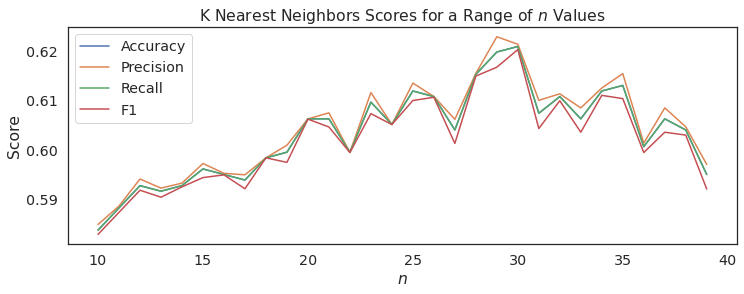

In [104]:
fig = plt.figure()
sns.lineplot(x="n", y="Accuracy", data=knn_df, label="Accuracy")
sns.lineplot(x="n", y="Precision", data=knn_df, label="Precision")
sns.lineplot(x="n", y="Recall", data=knn_df, label="Recall")
sns.lineplot(x="n", y="F1", data=knn_df, label="F1")
plt.title('K Nearest Neighbors Scores for a Range of $n$ Values')
plt.ylabel('Score')
plt.xlabel('$n$')
fig.set_size_inches(12,4)
plt.show()

Naive Bayes

In [105]:
for score in scores:
    print(f'Testing {score}')
    gnb = GaussianNB()
    params_NB = {'var_smoothing': np.logspace(0,-20, num=100)}
    gs_NB = GridSearchCV(estimator=gnb, 
                     param_grid=params_NB, 
                     verbose=1, 
                     scoring=score) 
    gs_NB.fit(X_train, y_train)
    print(gs_NB.best_params_)
    print(gs_NB.best_score_)

Testing accuracy
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'var_smoothing': 1.4174741629268048e-05}
0.6185857903184929
Testing precision_macro
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'var_smoothing': 1.0}
0.6288756143465447
Testing recall_macro
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'var_smoothing': 1.4174741629268048e-05}
0.6162390028106237
Testing f1_macro
Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'var_smoothing': 1.4174741629268048e-05}
0.6093919231445575


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.1s finished


In [106]:
params = gs_NB.best_params_
params

{'var_smoothing': 1.4174741629268048e-05}

In [107]:
gnb = GaussianNB(var_smoothing = params['var_smoothing'])
gnb.fit(X_train, y_train)
gnb_preds = gnb.predict(X_test)

In [108]:
print("Acc: " + str(skm.accuracy_score(y_true=y_test,y_pred=gnb_preds)))
print("Pre: " + str(skm.precision_score(y_true=y_test,y_pred=gnb_preds,average='weighted')))
print("Rec: " + str(skm.recall_score(y_true=y_test,y_pred=gnb_preds,average='weighted')))
print("F1:  " + str(skm.f1_score(y_true=y_test,y_pred=gnb_preds,average='weighted')))

Acc: 0.6197975253093363
Pre: 0.6328361288991211
Rec: 0.6197975253093363
F1:  0.6090263107355484


In [109]:
knn_cfmat = skm.confusion_matrix(
    y_true=y_test,
    y_pred=gnb_preds)

knn_cfmat

array([[200, 241],
       [ 97, 351]])

In [110]:
gnb_df = pd.DataFrame({'n':[], 'Accuracy':[],'Precision':[], 'Recall':[], 'F1':[]})
for i in np.logspace(0,-20, num=100):
    gnb = GaussianNB(var_smoothing=i)
    res = gnb.fit(X_train, y_train)
    y_hat = gnb.predict(X_test)
    acc = skm.accuracy_score(y_true=y_test,y_pred=y_hat)
    pre = skm.precision_score(y_true=y_test,y_pred=y_hat,average='weighted')
    rec = skm.recall_score(y_true=y_test,y_pred=y_hat,average='weighted')
    f1 = skm.f1_score(y_true=y_test,y_pred=y_hat,average='weighted')
    gnb_df = gnb_df.append({'n':i, 'Accuracy':acc,'Precision':pre, 'Recall':rec, 'F1':f1}, ignore_index=True)


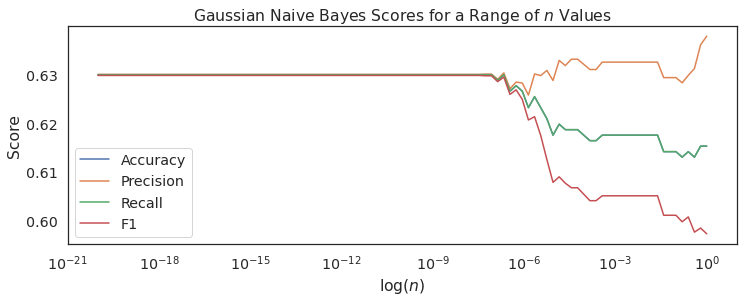

In [111]:
fig = plt.figure()
sns.lineplot(x="n", y="Accuracy", data=gnb_df, label="Accuracy")
sns.lineplot(x="n", y="Precision", data=gnb_df, label="Precision")
sns.lineplot(x="n", y="Recall", data=gnb_df, label="Recall")
sns.lineplot(x="n", y="F1", data=gnb_df, label="F1")
plt.title('Gaussian Naive Bayes Scores for a Range of $n$ Values')
plt.ylabel('Score')
plt.xlabel('$\log(n)$')
plt.xscale("log")
fig.set_size_inches(12,4)
plt.show()

Gradient Boosting

In [112]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                 max_depth=1, random_state=0)
clf.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)

In [113]:
GBC_pred = clf.predict(X_test)

In [114]:
print("Acc: " + str(skm.accuracy_score(y_true=y_test,y_pred=GBC_pred)))
print("Pre: " + str(skm.precision_score(y_true=y_test,y_pred=GBC_pred,average='weighted')))
print("Rec: " + str(skm.recall_score(y_true=y_test,y_pred=GBC_pred,average='weighted')))
print("F1:  " + str(skm.f1_score(y_true=y_test,y_pred=GBC_pred,average='weighted')))

Acc: 0.5916760404949382
Pre: 0.5930936715102393
Rec: 0.5916760404949382
F1:  0.5893833736813218


In [115]:
params = {'n_estimators':range(20,100,10), 'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
clf = GradientBoostingClassifier()
gridsearch = GridSearchCV(clf, params)
gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': range(5, 16, 2),
                         'min_samples_split': range(200, 1001, 200),
                         'n_estimators': range(20, 100, 10)})

In [116]:
gridsearch.best_score_

0.6140885922671848

In [117]:
gridsearch.best_params_

{'max_depth': 5, 'min_samples_split': 1000, 'n_estimators': 20}

In [126]:
clf = GradientBoostingClassifier(max_depth=5, min_samples_split=1000, n_estimators=20)
clf.fit(X_train, y_train)
clf_preds = clf.predict(X_test)

In [127]:
print("Acc: " + str(skm.accuracy_score(y_true=y_test,y_pred=clf_preds)))
print("Pre: " + str(skm.precision_score(y_true=y_test,y_pred=clf_preds,average='weighted')))
print("Rec: " + str(skm.recall_score(y_true=y_test,y_pred=clf_preds,average='weighted')))
print("F1:  " + str(skm.f1_score(y_true=y_test,y_pred=clf_preds,average='weighted')))

Acc: 0.6130483689538808
Pre: 0.6409804632161565
Rec: 0.6130483689538808
F1:  0.5911685822300177


In [131]:
pred_list = [knn_preds, gnb_preds, clf_preds]
accuracy = [round(skm.accuracy_score(y_true=y_test,y_pred=x),4) for x in pred_list]
precision = [round(skm.precision_score(y_true=y_test,y_pred=x,average='weighted'),4) for x in pred_list]
recall = [round(skm.recall_score(y_true=y_test,y_pred=x,average='weighted'),4) for x in pred_list]
f1 = [round(skm.f1_score(y_true=y_test,y_pred=x,average='weighted'),4) for x in pred_list]

In [132]:
models = ['K Nearest Neighbors', 'GaussianNB', 'Gradient Boosting']
all_results = pd.DataFrame({'Model':models, 'Accuracy':accuracy, 'Precision':precision,
                           'Recall':recall, 'F1':f1})

In [133]:
all_results.sort_values(by="F1", ascending=False)

,Model,Accuracy,Precision,Recall,F1
0,K Nearest Neighbors,0.6153,0.6155,0.6153,0.6149
1,GaussianNB,0.6198,0.6328,0.6198,0.6090
2,Gradient Boosting,0.6130,0.6410,0.6130,0.5912


In [123]:
gdb_df = pd.DataFrame({'n_estimators':[], 'Accuracy':[],'Precision':[], 'Recall':[], 'F1':[]})
for i in range(5,100,5):
    gdb = GradientBoostingClassifier(n_estimators=i, max_depth=5, min_samples_split=1000)
    res = gdb.fit(X_train, y_train)
    y_hat = gdb.predict(X_test)
    acc = skm.accuracy_score(y_true=y_test,y_pred=y_hat)
    pre = skm.precision_score(y_true=y_test,y_pred=y_hat,average='weighted')
    rec = skm.recall_score(y_true=y_test,y_pred=y_hat,average='weighted')
    f1 = skm.f1_score(y_true=y_test,y_pred=y_hat,average='weighted')
    gdb_df = gdb_df.append({'n_estimators':i, 'Accuracy':acc,'Precision':pre, 'Recall':rec, 'F1':f1}, ignore_index=True)


In [124]:
gdb_df

,n_estimators,Accuracy,Precision,Recall,F1
0,5.0,0.615298,0.645329,0.615298,0.592639
1,10.0,0.613048,0.640980,0.613048,0.591169
2,15.0,0.613048,0.640980,0.613048,0.591169
3,20.0,0.613048,0.640980,0.613048,0.591169
4,25.0,0.613048,0.640980,0.613048,0.591169
5,30.0,0.613048,0.640980,0.613048,0.591169
6,35.0,0.613048,0.640980,0.613048,0.591169
7,40.0,0.613048,0.640980,0.613048,0.591169
8,45.0,0.613048,0.640980,0.613048,0.591169
9,50.0,0.609674,0.634355,0.609674,0.589161


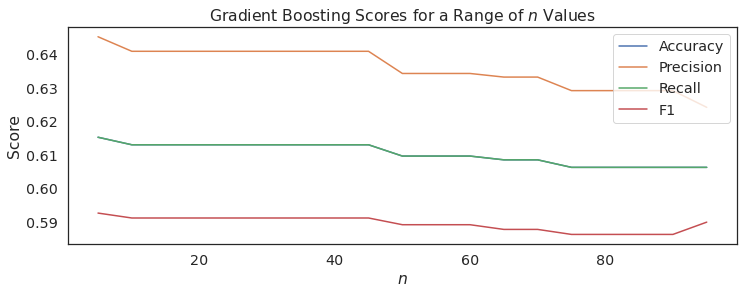

In [125]:
fig = plt.figure()
sns.lineplot(x="n_estimators", y="Accuracy", data=gdb_df, label="Accuracy")
sns.lineplot(x="n_estimators", y="Precision", data=gdb_df, label="Precision")
sns.lineplot(x="n_estimators", y="Recall", data=gdb_df, label="Recall")
sns.lineplot(x="n_estimators", y="F1", data=gdb_df, label="F1")
plt.title('Gradient Boosting Scores for a Range of $n$ Values')
plt.ylabel('Score')
plt.xlabel('$n$')
fig.set_size_inches(12,4)
plt.show()